# Module

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import warnings
warnings.filterwarnings('ignore')
import time
import math

In [2]:
df = pd.read_csv('/home/xogns5037/딥러닝코딩스터디/seq2seq_attention/ChatbotData.csv')
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
question = df['Q']
answer = df['A']

# Data preprocessing

In [4]:
import re

# 한글, 영어, 숫자, 공백, ?!.,을 제외한 나머지 문자 제거
korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'

# 패턴 컴파일
normalizer = re.compile(korean_pattern)

In [5]:
def normalize(sentence):
    return normalizer.sub("", sentence)

## 형태소 분석기

In [6]:
from konlpy.tag import Okt

In [7]:
okt = Okt()

In [8]:
# 한글 전처리를 함수화
def clean_text(sentence):
    sentence = normalize(sentence)
    sentence = okt.morphs(sentence) # okt.morphs : 형태소 분석기
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    return sentence

In [9]:
len(question), len(answer)

(11823, 11823)

In [10]:
questions = [clean_text(sent) for sent in question.values]
answers = [clean_text(sent) for sent in answer.values]

In [11]:
questions[:3]

['12시 땡 !', '1 지망 학교 떨어졌어', '3 박 4일 놀러 가고 싶다']

In [12]:
answers[:3]

['하루 가 또 가네요 .', '위로 해 드립니다 .', '여행 은 언제나 좋죠 .']

## 단어 사전 생성

In [13]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
class WordVocab():
    def __init__(self):
        # Special token
        SOS_TOKEN = 0 # Start of sentence
        EOS_TOKEN = 1 # End of sentence
        UNKNOWN_TOKEN = 2 # Unknown word token
        
        self.unknown_token = UNKNOWN_TOKEN
        
        # 각 토큰 별 word count
        self.word2count = {}
        
        # word -> idx
        self.word2index = {
            '<SOS>': SOS_TOKEN, 
            '<EOS>': EOS_TOKEN,
            '<UKN>': UNKNOWN_TOKEN,
        }

        # idx -> word
        self.index2word = {
            SOS_TOKEN: '<SOS>', 
            EOS_TOKEN: '<EOS>', 
            UNKNOWN_TOKEN: '<UKN>',
        }
        
        # total word counts
        self.n_words = 3  # SOS, EOS, UNKNOWN 포함

    # 문장으로 추가 시
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    # 단어 사전 등록
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    # 단어를 index로 변환
    def word_to_index(self, word):
        if word in self.word2index:
            return self.word2index[word]
        else:
            return self.unknown_token
        
    # index를 단어로 변환
    def index_to_word(self, idx):
        return self.index2word[idx]

## Torch dataset

In [15]:
class QADataset():
    def __init__(self, q, a, max_length=30):
        self.q = q
        self.a = a
        self.max_length = max_length # 한 문장의 최대 길이 지정
        self.SOS_TOKEN = 0 # SOS 토큰
        self.EOS_TOKEN = 1 # EOS 토큰
        # 단어 사전 생성
        wordvocab = WordVocab()
        
        for x, y in zip(q,a):
    
            wordvocab.add_sentence(x)
            wordvocab.add_sentence(y)       
        
        self.wordvocab = wordvocab
    
    def texts_to_sequences(self, sentence):
        # 문장 -> 시퀀스로 변환
        sequences = [self.wordvocab.word_to_index(w) for w in sentence.split()]
        # 문장 최대 길이 -1 까지 슬라이싱
        sequences = sequences[:self.max_length-1]
        # 맨 마지막에 EOS TOKEN 추가
        sequences.append(self.EOS_TOKEN)
        return sequences
    
    def sequences_to_texts(self, sequences):
        # 시퀀스 -> 문장으로 변환
        sentences = [self.wordvocab.index_to_word(s.item()) for s in sequences]
        return ' '.join(sentences)

    
    def __getitem__(self, idx):
        inputs = self.q[idx]
        inputs_sequences = self.texts_to_sequences(inputs)
        
        outputs = self.a[idx]
        outputs_sequences = self.texts_to_sequences(outputs)
        
        return torch.tensor(inputs_sequences).view(-1, 1), torch.tensor(outputs_sequences).view(-1, 1)
    
    def __len__(self):
        return len(self.q)

In [16]:
dataset = QADataset(questions,answers)

In [17]:
dataset[3]

(tensor([[18],
         [19],
         [20],
         [28],
         [21],
         [22],
         [23],
         [ 1]]),
 tensor([[24],
         [25],
         [26],
         [27],
         [10],
         [ 1]]))

In [18]:
x, y = dataset[3]

# 시퀀스를 문장으로 변환
print(dataset.sequences_to_texts(x))
print(dataset.sequences_to_texts(y))

3 박 4일 정도 놀러 가고 싶다 <EOS>
여행 은 언제나 좋죠 . <EOS>


# 모형

## Encoder

In [19]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers):
        super(Encoder, self).__init__()
        
        # 단어 사전의 개수 지정
        self.num_vocabs = num_vocabs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        # 임베딩 레이어 정의 (number of vocabs, embedding dimension)
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        # GRU (embedding dimension)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False, 
                          batch_first=True,
                         )
        
    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        # x: (1, 1, embedding_dim)
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        output, hidden = self.gru(x, hidden)
        # output: (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return output, hidden
    
    def init_hidden(self, device):
        # hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32)) 로 초기화
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Decoder

In [20]:
class AttentionDecoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, dropout_p=0.1, max_length=30):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length

        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.attn = nn.Linear(hidden_size + embedding_dim , max_length)
        self.attn_combine = nn.Linear(hidden_size + embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, num_vocabs)

    def forward(self, x, hidden, encoder_outputs):
        # x: (1, 1) 1개의 토큰
        embedded = self.embedding(x).view(1, 1, -1)
        # embedded: (1, 1, 1)
        embedded = self.dropout(embedded)
        x = self.gru(embedded)

        
        # embedded[0]: (1, embedding_dim)
        # hidden[0]: (1, hidden_size)
        attn_in = torch.cat((x[0], hidden[0]), 1)
        # attn_in: (1, embedding_dim + hidden_size)
                            
        attn = self.attn(attn_in)
        # attn: (1, max_length)
                         
        attn_weights = F.softmax(attn)
        # attn_weights: (1, max_length)
        
        # (1, 1, max_length), (1, max_length, hidden_size)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # attn_applied: (1, 1, hidden_size)

        # embedded[0]: (1, embedding_dim)
        # attn_applied[0]: (1, hidden_size)
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # output: (1, embedding_dim + hidden_size)
        
        output = self.attn_combine(output)
        # output: (1, hidden_size)
        output = output.unsqueeze(0)
        # output: (1, 1, hidden_size)

        output = F.relu(output)
        # output: (1, 1, hidden_size)
        
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        output, hidden = self.gru(output, hidden)
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        
        # output[0]: (1, hidden_size)
        output = self.out(output[0])
        # output: (1, number of vocabs)
        
        # output[0]: (number of vocabs)
        # hidden: (1, 1, hidden_size)
        # attn_weights: (1, max_length)
        return output[0], hidden, attn_weights

    def initHidden(self, device):
        # (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return torch.zeros(1, 1, self.hidden_size, device=device)

# 학습

In [21]:
SOS_TOKEN = dataset.SOS_TOKEN
EOS_TOKEN = dataset.EOS_TOKEN

In [22]:
# 훈련시 training loss 를 출력하기 위한 util 함수
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title('Losses over training')
    plt.show()
    
# 훈련시 시간 출력을 위한 util 함수
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{int(m)}m {int(s)}s'

# 훈련시 시간 출력을 위한 util 함수
def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{as_minutes(s)} (remaining: {as_minutes(rs)})'

In [23]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, device, max_length=30, teacher_forcing_ratio=0.5):
    
    # Encoder의 hidden_state 초기화
    encoder_hidden = encoder.init_hidden(device=device)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # input_length: 입력 문장의 길이
    # target_length: 출력 문장의 길이
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Encoder의 출력 결과를 담을 tensor
    # (문장의 max_length, encoder의 hidden_size)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Encoder의 출력을 encoder_outputs[ei] 에 저장
        # encoder_output[0, 0]: (hidden_size,)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Decoder의 첫 토큰은 SOS_TOKEN
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)

    # Encoder의 마지막 hidden state를 Decoder의 초기 hidden state로 지정
    decoder_hidden = encoder_hidden

    # teacher forcing 적용 여부 확률로 결정
    # teacher forcing 이란: 정답치를 다음 RNN Cell의 입력으로 넣어주는 경우. 수렴속도가 빠를 수 있으나, 불안정할 수 있음
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

        # loss 계산
        loss += criterion(decoder_output.view(1, -1), target_tensor[di])

        if use_teacher_forcing:
            # teacher forcing 적용: 정답 값 입력
            decoder_input = target_tensor[di]
        else:
            # 확률, 인덱스
            topv, topi = decoder_output.topk(1)
            # 다음 입력으로 주입할 디코더 최종 토큰 결정
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

        # EOS_TOKEN 이면 종료
        if decoder_input.item() == EOS_TOKEN:
            break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [24]:
def train_iterations(encoder, decoder, n_iters, dataset, device, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    # 랜덤 샘플링된 데이터셋 생성
    training_pairs = [dataset[random.randint(0, len(dataset)-1)] for i in range(n_iters)]
    
    # Loss Function 정의
    criterion = nn.CrossEntropyLoss()

    # n_iters 만큼 training 시작
    for iter in range(1, n_iters + 1):
        # 문장 pair
        training_pair = training_pairs[iter - 1]        
        # 입력 문장
        input_tensor = training_pair[0]
        # 출력 문장
        target_tensor = training_pair[1]
        
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # 훈련
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
                     decoder_optimizer, criterion, device)
        
        print_loss_total += loss
        plot_loss_total += loss

        # print_every 마다 loss 출력
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{time_since(start, iter/n_iters)} iter: {iter} ({iter/n_iters*100:.1f}%), loss: {print_loss_avg:.4f}')

        # plot_every 마다 loss 시각화
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [25]:
NUM_VOCABS = dataset.wordvocab.n_words
HIDDEN_SIZE = 512
EMBEDDING_DIM = 256
DROPOUT_P = 0.1

# Encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  num_layers=1)

# Attention 이 적용된 Decoder 정의
decoder = AttentionDecoder(num_vocabs=NUM_VOCABS, 
                           hidden_size=HIDDEN_SIZE, 
                           embedding_dim=EMBEDDING_DIM, 
                           dropout_p=DROPOUT_P, 
                           max_length=30)

# encoder, decoder 생성 및 device 지정
encoder = encoder.to(device)
decoder = decoder.to(device)

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


/tmp/ipykernel_82810/4007744478.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = F.softmax(attn)


2m 57s (remaining: 56m 12s) iter: 5000 (5.0%), loss: 4.8963
5m 41s (remaining: 51m 16s) iter: 10000 (10.0%), loss: 4.2910
8m 27s (remaining: 47m 57s) iter: 15000 (15.0%), loss: 3.8696
11m 13s (remaining: 44m 52s) iter: 20000 (20.0%), loss: 3.5667
13m 57s (remaining: 41m 52s) iter: 25000 (25.0%), loss: 3.3599
16m 43s (remaining: 39m 0s) iter: 30000 (30.0%), loss: 3.1994
19m 28s (remaining: 36m 9s) iter: 35000 (35.0%), loss: 3.0567
22m 14s (remaining: 33m 22s) iter: 40000 (40.0%), loss: 3.0197
25m 2s (remaining: 30m 36s) iter: 45000 (45.0%), loss: 2.9216
27m 50s (remaining: 27m 50s) iter: 50000 (50.0%), loss: 2.8294
30m 38s (remaining: 25m 4s) iter: 55000 (55.0%), loss: 2.7698
33m 26s (remaining: 22m 17s) iter: 60000 (60.0%), loss: 2.7092
36m 13s (remaining: 19m 30s) iter: 65000 (65.0%), loss: 2.6680
39m 0s (remaining: 16m 43s) iter: 70000 (70.0%), loss: 2.6398
41m 48s (remaining: 13m 56s) iter: 75000 (75.0%), loss: 2.5616
44m 35s (remaining: 11m 8s) iter: 80000 (80.0%), loss: 2.4629
47m

<Figure size 640x480 with 0 Axes>

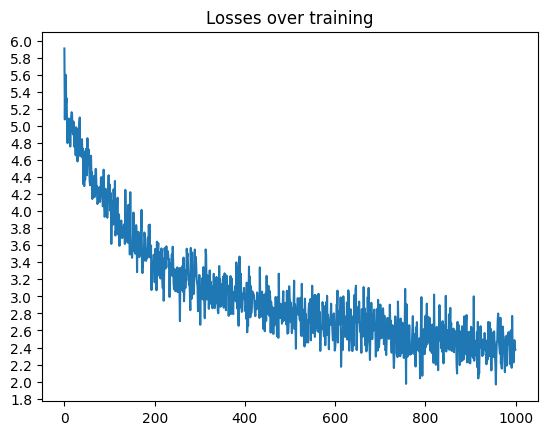

In [38]:
train_iterations(encoder, decoder, 100000, dataset, device, print_every=5000)

# 추론

In [39]:
def evaluate(encoder, decoder, input_tensor, dataset, device, max_length=30):
    # Eval 모드 설정
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        input_length = input_tensor.size(0)
        # Encoder의 hidden state 초기화
        encoder_hidden = encoder.init_hidden(device=device)

        # encoder_outputs는 Encoder를 통과한 문장의 출력
        # (max_length, hidden_size)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Encoder 에 입력 문자 주입 후 encoder_outputs 생성
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        # Decoder의 첫 번째 입력으로 SOS_TOKEN 입력(SOS_TOKEN=0)
        decoder_input = torch.tensor([[0]], device=device)

        # Decoder의 첫 번째 hidden state는 Encoder의 마지막 hidden state 사용
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # 1개의 Decoder 입력 토큰을 통과
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # Attention 시각화를 위한 tensor 저장
            decoder_attentions[di] = decoder_attention.data

            # 출력 토큰 예측
            topv, topi = decoder_output.data.topk(1)

            # EOS_TOKEN이면 종료
            if topi.item() == dataset.EOS_TOKEN:
                decoded_words.append('<EOS>')
                break
            else:
                # 출력 문장에 토큰 시퀀스(index)를 단어(word)로 변환한 후 저장
                decoded_words.append(dataset.wordvocab.index_to_word(topi.item()))

            # decoder_input은 다음 토큰 예측시 입력 값
            # decoder_input: (hidden_size,)
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
    
def evaluate_randomly(encoder, decoder, dataset, device, n=10):
    for i in range(n):
        # 랜덤 샘플링
        x, y = random.choice(dataset)
        # 입력 문장, 출력 문장 (Ground Truth)
        print('>', dataset.sequences_to_texts(x))
        print('=', dataset.sequences_to_texts(y))

        # 예측
        output_words, attentions = evaluate(encoder, decoder, x.to(device), dataset, device)
        output_sentence = ' '.join(output_words)
        
        # 예측 문장 출력
        print('<', output_sentence)
        print('')

# Attention 가중치 시각화 

/tmp/ipykernel_82810/4007744478.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = F.softmax(attn)


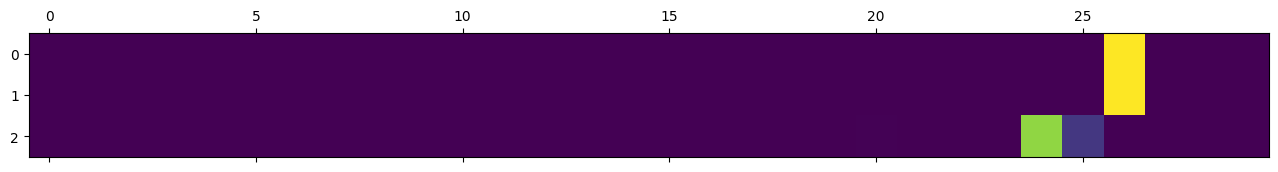

In [40]:
# Attention Weights를 활용한 시각화
output_words, attentions = evaluate(encoder, decoder, dataset[2][0].to(device), dataset, device)
plt.matshow(attentions.numpy())
plt.show()

In [41]:
# Attention 시각화를 위한 함수
def show_attention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    plt.rcParams['font.family'] = 'AppleGothic' # mac 사용자 한글 폰트 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(encoder, decoder, input_sentence, dataset, device):
    output_words, attentions = evaluate(encoder, decoder, input_sentence.to(device), dataset, device)
    input_sentence = dataset.sequences_to_texts(input_sentence)
    output_words = ' '.join(output_words)
    print('input =', input_sentence)
    print('output =', output_words)
    show_attention(input_sentence, output_words.split(), attentions)

/tmp/ipykernel_82810/4007744478.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = F.softmax(attn)
/tmp/ipykernel_82810/1143270574.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipykernel_82810/1143270574.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)
/home/as9786/.conda/envs/as3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/as9786/.conda/envs/as3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/as9786/.conda/envs/as3/lib/python3

input = 3 박 4일 놀러 가고 싶다 <EOS>
output = 친구 은 <EOS>


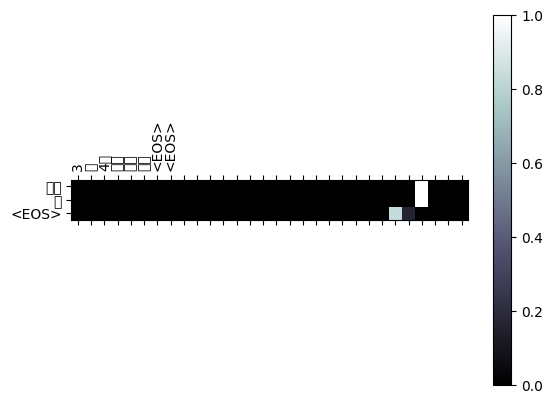

In [42]:
evaluate_and_show_attention(encoder, decoder, dataset[2][0], dataset, device)